In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __init__ import *
from runner.svg2plan import run_new_layout
from new_solutions.selection import *
from domains.domain import Domain

import plotly.io as pio
pio.renderers.default = "browser"

from fixes.problem_types.side_hole_id2 import *
from visuals.plots import make_subplot_for_all_probs
from export.saver import read_pickle, save_pickle
from actions.details import Details
from helpers.shapely import shape_to_domain
from actions.interfaces import CurrentDomains
from fixes.problem_types.overlap_id import *

In [16]:
report = run_new_layout()

executer> 
 begining to execute stacking


In [18]:
re = Reporter(report.layout)
re.run()
re.problems

[Problem(ix=1, OVERLAP, ['m_closet', 'dining'], resolved=False,  n_actions=2,
 Problem(ix=2, OVERLAP, ['m_bedroom', 'dining'], resolved=False,  n_actions=4,
 Problem(ix=3, OVERLAP, ['m_bedroom', 'bath'], resolved=False,  n_actions=2]

In [4]:
rl:ResultsLog = read_pickle("dining_squeeze_sidehole")
p = check_for_side_holes(rl.layout)
p

[(Domain(dining, x=[5.02-7.14], y=[-5.68--2.53]),
  Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]),
  'x')]

In [14]:
re = Reporter(rl.layout)
re.run()

In [15]:
re.problems

[Problem(ix=1, SIDE_HOLE, ['dining', 'closet'], resolved=False,  n_actions=2]

In [13]:
res = create_side_hole_problems(rl.layout)
res[0].action_details

[dining-WEST-1.24, closet-EAST-1.24]

In [9]:
cmp = p[0][0].compare_domains(p[0][1])
cmp.get_domain_directions(p[0][0])

[<Direction.WEST: 3>]

In [10]:
get_axis(cmp.get_domain_directions(p[0][0])[0])

'x'

In [14]:
re.problems

[Problem(ix=1, OVERLAP, ['m_bedroom', 'dining'], resolved=False,  n_actions=4,
 Problem(ix=2, OVERLAP, ['m_bedroom', 'bath'], resolved=False,  n_actions=2,
 Problem(ix=3, OVERLAP, ['m_closet', 'dining'], resolved=False,  n_actions=2]

In [9]:
ov = create_overlap_problems(report.layout)
ov

[Problem(ix=0, OVERLAP, ['m_bedroom', 'bath'], resolved=False,  n_actions=2,
 Problem(ix=1, OVERLAP, ['m_bedroom', 'dining'], resolved=False,  n_actions=4,
 Problem(ix=2, OVERLAP, ['m_closet', 'dining'], resolved=False,  n_actions=2]

In [8]:
ov[2].action_details

[m_closet EAST, sz=0.18, dining WEST, sz=0.18]

In [5]:
d = Decimal("20")
print(f" {d}")

 20


In [6]:
res = [create_action_details(o, report.layout.domains) for o in ov]
res

[[node:m_bedroom, EAST, sz=0.20, node:bath, WEST, sz=0.20],
 [node:m_bedroom, NORTH, sz=0.21,
  node:m_bedroom, EAST, sz=1.24,
  node:dining, SOUTH, sz=0.21,
  node:dining, WEST, sz=1.24],
 [node:m_closet, EAST, sz=0.18, node:dining, WEST, sz=0.18]]

In [13]:
res[1].get_axis()

['x', 'y']

In [9]:
res[1].get_domain_directions(report.layout.domains["m_bedroom"])

['NORTH', 'EAST']

In [5]:
plot_general(report.layout.domains)

problem being studied: -> Problem(index=5, problem_type=ProblemType.OVERLAP, resolved=False, nbs=('bath', 'transit_space')
first bl to try -> node: bath, action: SQUEEZE, summary: Counter({'OVERLAP': 2, 'HOLE': 1}), # unres probs: 3
next best layout node: bath, action: SQUEEZE, summary: Counter({'OVERLAP': 2, 'HOLE': 1}), # unres probs: 3
running again -> 2


In [39]:
c.run_again()

problem being studied: -> Problem(index=4, problem_type=ProblemType.HOLE, resolved=False, nbs=['transit_space', 'laundry', 'm_bath', 'bath']
first bl to try -> node: bath, action: STRETCH, summary: Counter({'OVERLAP': 3}), # unres probs: 3
skipping bc prev domains are in history
skipping bc prev domains are in history
next best layout node: laundry, action: STRETCH, summary: Counter({'OVERLAP': 3}), # unres probs: 3
running again -> 3


In [40]:
c.run_again()

problem being studied: -> Problem(index=4, problem_type=ProblemType.OVERLAP, resolved=False, nbs=('m_bath', 'laundry')
first bl to try -> node: laundry, action: SQUEEZE, summary: Counter({'OVERLAP': 2}), # unres probs: 2
next best layout node: laundry, action: SQUEEZE, summary: Counter({'OVERLAP': 2}), # unres probs: 2
running again -> 4


In [41]:
c.run_again()

problem being studied: -> Problem(index=1, problem_type=ProblemType.OVERLAP, resolved=False, nbs=('m_bedroom', 'dining')
first bl to try -> node: dining, action: SQUEEZE, summary: Counter(), # unres probs: 0
next best layout node: dining, action: SQUEEZE, summary: Counter(), # unres probs: 0
running again -> 5


In [43]:
make_subplot_for_all_probs(c.history[0], c.bl_hist)

len sols = 5. Len indices = 9


In [5]:
ld: ResultsLog = read_layout("dining_squeeze_sidehole")
ld

node: dining, action: SQUEEZE, summary: Counter({'SIDE_HOLE': 1}), # unres probs: 1

In [6]:
plot_general(ld.layout.domains, "sidehole start")

In [7]:
ld_doms = ld.layout.domains
ld_doms

{'bedroom_1': Domain(bedroom_1, x=[0.00-3.22], y=[-2.80-0.00]),
 'kitchen': Domain(kitchen, x=[3.22-5.02], y=[-5.77--3.53]),
 'm_bath': Domain(m_bath, x=[4.82-7.14], y=[-1.30-0.00]),
 'm_bedroom': Domain(m_bedroom, x=[7.14-9.27], y=[-2.74-0.00]),
 'm_closet': Domain(m_closet, x=[8.20-9.20], y=[-3.34--2.74]),
 'bath': Domain(bath, x=[5.02-7.14], y=[-2.53--1.30]),
 'dining': Domain(dining, x=[5.02-7.14], y=[-5.68--2.53]),
 'transit_space': Domain(transit_space, x=[3.22-5.02], y=[-3.53--1.30]),
 'closet': Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]),
 'bedroom_2': Domain(bedroom_2, x=[0.00-3.22], y=[-5.95--2.80]),
 'laundry': Domain(laundry, x=[3.22-4.82], y=[-1.30-0.45])}

In [8]:
ld.problem_being_addressed

Problem(index=2, problem_type=ProblemType.OVERLAP, resolved=False, nbs=('m_bedroom', 'dining')

In [9]:
re = Reporter(ld.layout)
re.run()

shid Domain(dining, x=[5.02-7.14], y=[-5.68--2.53]) Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]) x


In [17]:
re.problems[0]

Problem(index=1, problem_type=ProblemType.SIDE_HOLE, resolved=False, nbs=['dining', 'closet']

In [14]:
sop = StudyOneProblem(ld.layout, ld.summary, re.problems, problem=re.problems[0])
sop.run()

shid Domain(dining, x=[5.02-7.14], y=[-8.02--2.53]) Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]) x
shid Domain(dining, x=[5.02-7.14], y=[-8.02--4.87]) Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]) x
shid Domain(kitchen, x=[3.22-5.02], y=[-5.77--3.53]) Domain(dining, x=[6.26-8.38], y=[-5.68--2.53]) x


In [23]:
save_pickle(sop.results[-1], "diagonal_hole")

'diagonal_hole'

In [25]:
dh: ResultsLog = read_pickle("diagonal_hole")
dh

node: closet, action: PULL, summary: Counter(), # unres probs: 0

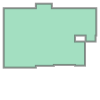

In [32]:
u = union_all(list(dh.layout.shapes.values()))
u

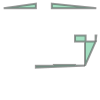

In [35]:
u.convex_hull.difference(u)

In [26]:
plot_general(dh.layout.domains, "diag_hole")

In [16]:
make_subplot_for_all_probs(ld.layout.domains, sop.results)

len sols = 8. Len indices = 9


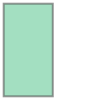

In [8]:
re.problems[0].geometry

In [11]:
pdom = shape_to_domain(re.problems[0].geometry, "problem")
pdom

Domain(problem, x=[7.14-8.38], y=[-5.68--3.34])

In [20]:
sorted([ld_doms["closet"],ld_doms["dining"]], key=lambda d: d.y.min)

[Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]),
 Domain(dining, x=[5.02-7.14], y=[-5.68--2.53])]

In [18]:
ld_doms["closet"]

Domain(closet, x=[8.38-9.38], y=[-5.75--3.34])

In [19]:
ld_doms["dining"]

Domain(dining, x=[5.02-7.14], y=[-5.68--2.53])

In [12]:
det = Details(CurrentDomains(ld_doms["dining"], pdom))
det.run()
det.result

[(Decimal('2.34'), <Direction.NORTH: 0>),
 (Decimal('1.24'), <Direction.WEST: 3>)]

In [15]:
det = Details(CurrentDomains(ld_doms["closet"], pdom))
det.run()
det.result

[(Decimal('2.34'), <Direction.SOUTH: 1>),
 (Decimal('1.24'), <Direction.EAST: 2>)]

In [13]:
from actions.actions import create_node_operations


create_node_operations(CurrentDomains(ld_doms["closet"], pdom), ProblemType.SIDE_HOLE)

[OperationLog(node=Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]), action_type=<ActionType.STRETCH: 3>, modified_domain=Domain(closet, x=[8.38-9.38], y=[-5.75--1.00])),
 OperationLog(node=Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]), action_type=<ActionType.PULL: 2>, modified_domain=Domain(closet, x=[8.38-9.38], y=[-3.41--1.00])),
 OperationLog(node=Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]), action_type=<ActionType.STRETCH: 3>, modified_domain=Domain(closet, x=[7.14-9.38], y=[-5.75--3.34])),
 OperationLog(node=Domain(closet, x=[8.38-9.38], y=[-5.75--3.34]), action_type=<ActionType.PULL: 2>, modified_domain=Domain(closet, x=[7.14-8.14], y=[-5.75--3.34]))]

In [16]:
ld_doms["closet"]

Domain(closet, x=[8.38-9.38], y=[-5.75--3.34])